In [44]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.metrics import mean_absolute_error as mae

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/visits.csv

--2019-10-11 17:46:16--  https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/visits.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3596203 (3.4M) [text/plain]
Saving to: ‘visits.csv’

visits.csv          100%[===================>]   3.43M  --.-KB/s    in 0.1s    

2019-10-11 17:46:17 (30.9 MB/s) - ‘visits.csv’ saved [3596203/3596203]



In [5]:
df = pd.read_csv('visits.csv', parse_dates=['published'], index_col='published')
df.head()

,post_id
published,
2008-01-01 18:19:00,18284
2008-01-01 18:30:00,18285
2008-01-01 18:34:00,18286
2008-01-02 01:32:00,18291
2008-01-02 14:34:00,18294


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134137 entries, 2008-01-01 18:19:00 to 2016-10-31 23:56:00
Data columns (total 1 columns):
post_id    134137 non-null int64
dtypes: int64(1)
memory usage: 2.0 MB


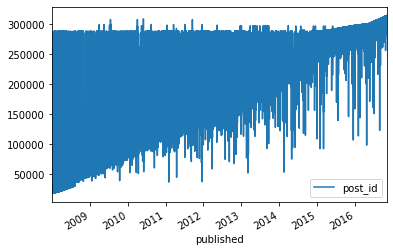

In [8]:
df.plot();

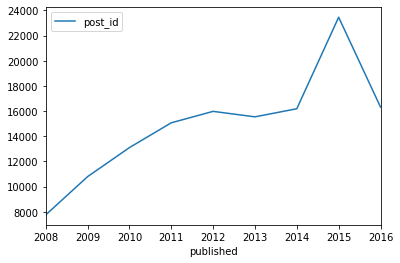

In [14]:
df.resample('1y').count().plot();

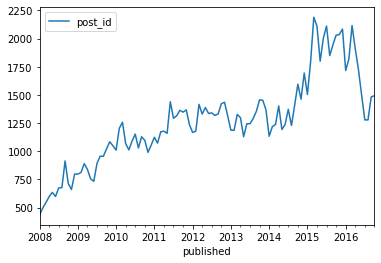

In [15]:
df.resample('1m').count().plot();

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


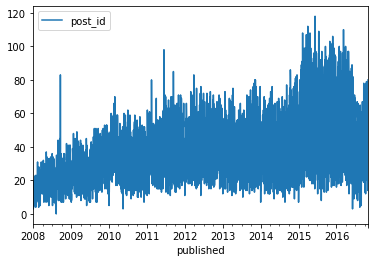

In [16]:
df.resample('1d').count().plot();

In [17]:
df_day = df.resample('1d').count().reset_index()
df_day.columns = ['ds', 'y']
df_day

,ds,y
0,2008-01-01,3
1,2008-01-02,3
2,2008-01-03,4
3,2008-01-04,14
4,2008-01-05,4
...,...,...
3222,2016-10-27,58
3223,2016-10-28,53
3224,2016-10-29,14
3225,2016-10-30,27


In [51]:
num_points_to_pred = 100

train = df_day[:-num_points_to_pred]
test = df_day[-num_points_to_pred:]

In [52]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [53]:
future = m.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=True)
future

,ds
0,2008-01-01
1,2008-01-02
2,2008-01-03
3,2008-01-04
4,2008-01-05
...,...
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30


In [54]:
forecast = m.predict(future)

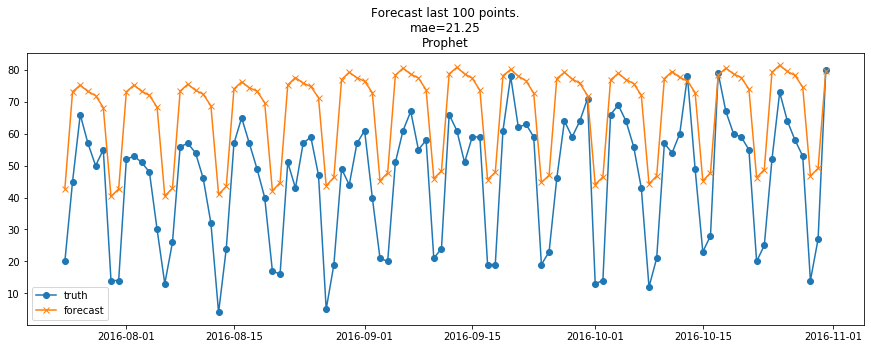

In [55]:
def plot_forecast(test, forecast):
    forecast = forecast[-num_points_to_pred:]
    score = np.round(mae(test.y, forecast.yhat), 2)
    plt.figure(figsize=(15, 5))
    plt.title('Forecast last {} points.\nmae={}\nProphet'.format(num_points_to_pred, score))
    plt.plot(test.ds, test.y, 'o-', label='truth');
    plt.plot(test.ds, forecast.yhat, 'x-', label='forecast');
    plt.legend();
    
plot_forecast(test, forecast)

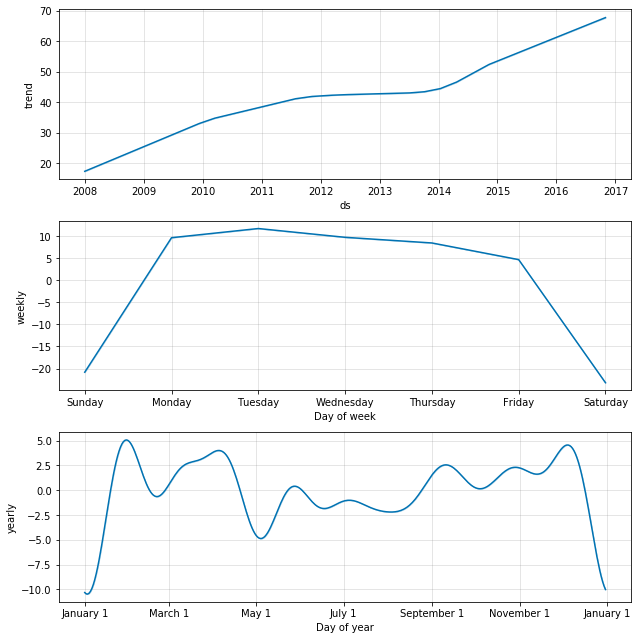

In [56]:
m.plot_components(forecast);

In [57]:
len(train), len(test)

(3127, 100)

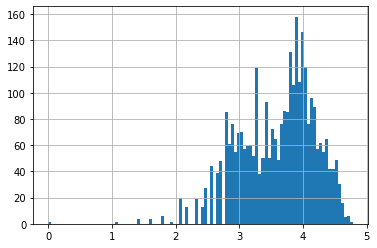

In [58]:
np.log1p(train.y).hist(bins=100);

In [59]:
num_points_to_pred = 100

train = df_day[:-num_points_to_pred]
test = df_day[-num_points_to_pred:]

train_log = train.copy()
train_log['y'] = np.log1p(train_log['y'])

In [64]:
m = Prophet(changepoint_prior_scale=0.01)
m.fit(train_log)
future = m.make_future_dataframe(periods=num_points_to_pred, freq='D', include_history=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [65]:
forecast = m.predict(future)
forecast['yhat'] = np.expm1(forecast.yhat)

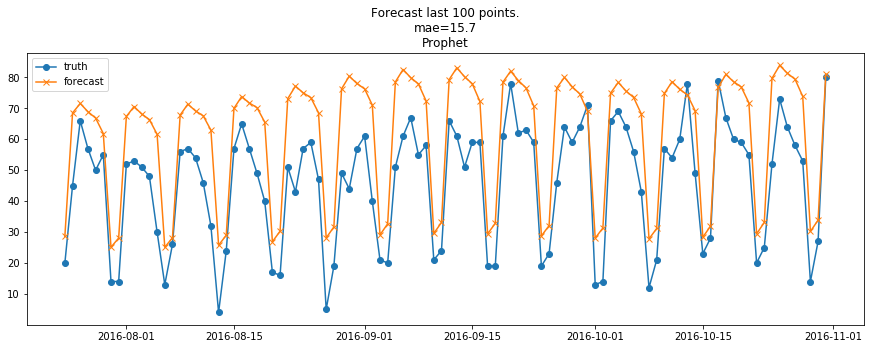

In [66]:
plot_forecast(test, forecast)

In [40]:
df_cv = cross_validation(m, initial='2500 days', period='10 days', horizon='30 days')

INFO:fbprophet:Making 67 forecasts with cutoffs between 2014-11-11 00:00:00 and 2016-09-01 00:00:00


In [41]:
df_cv.shape

(2010, 6)

In [42]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-11-12,52.398665,40.914415,63.873497,75,2014-11-11
1,2014-11-13,51.135341,39.177861,62.737557,72,2014-11-11
2,2014-11-14,48.724733,37.036996,60.063251,60,2014-11-11
3,2014-11-15,25.671027,13.997115,37.379443,20,2014-11-11
4,2014-11-16,26.743300,14.857214,37.911618,26,2014-11-11
...,...,...,...,...,...,...
2005,2016-09-27,73.230752,57.842739,86.518104,64,2016-09-01
2006,2016-09-28,71.154727,57.191731,85.577839,59,2016-09-01
2007,2016-09-29,69.736696,55.354640,83.774121,64,2016-09-01
2008,2016-09-30,65.826579,51.224607,80.662699,71,2016-09-01


In [46]:
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-11-11,30,30,30,30,30
2014-11-21,30,30,30,30,30
2014-12-01,30,30,30,30,30
2014-12-11,30,30,30,30,30
2014-12-21,30,30,30,30,30
...,...,...,...,...,...
2016-07-23,30,30,30,30,30
2016-08-02,30,30,30,30,30
2016-08-12,30,30,30,30,30


In [47]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,coverage
0,3 days,370.880636,19.258261,16.290693,0.564985,0.422886
1,4 days,335.711357,18.322428,15.725948,0.435991,0.412935
2,5 days,347.337215,18.636985,15.837603,0.477355,0.432836
3,6 days,350.526290,18.722347,15.645785,0.460709,0.462687
4,7 days,378.171895,19.446642,16.192848,0.468657,0.447761
5,8 days,369.704813,19.227710,15.850465,0.437131,0.467662
6,9 days,360.750587,18.993435,15.729791,0.436257,0.457711
7,10 days,403.976353,20.099163,16.484744,0.472290,0.447761
8,11 days,417.601795,20.435308,16.723957,0.585816,0.437811
9,12 days,424.907083,20.613274,17.236055,0.588839,0.407960


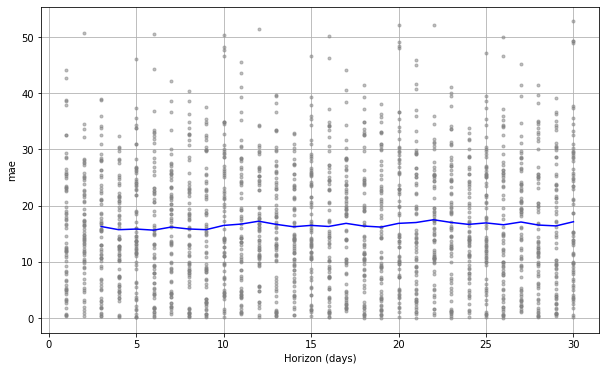

In [48]:
plot_cross_validation_metric(df_cv, 'mae');

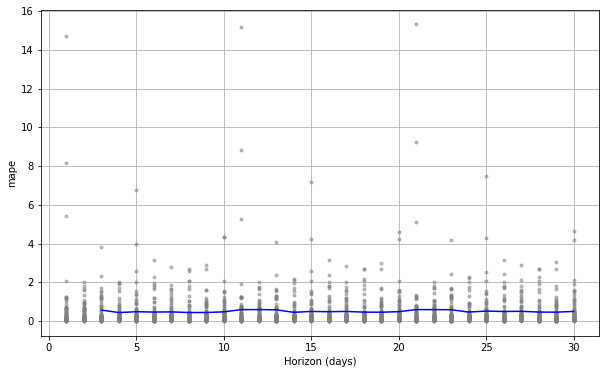

In [49]:
plot_cross_validation_metric(df_cv, 'mape');